# Data Processing

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)

df = pd.read_csv("FPA-FOD_39attributes.csv", low_memory = False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9187 entries, 0 to 9186
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            9187 non-null   int64  
 1   DISCOVERY_DOY         9187 non-null   int64  
 2   FIRE_YEAR             9187 non-null   int64  
 3   STATE                 9187 non-null   object 
 4   FIPS_CODE             9187 non-null   float64
 5   Annual_etr            9187 non-null   int64  
 6   Annual_precipitation  9187 non-null   int64  
 7   Annual_tempreture     9187 non-null   float64
 8   pr                    9187 non-null   float64
 9   tmmn                  9187 non-null   float64
 10  vs                    9187 non-null   float64
 11  fm100                 9187 non-null   float64
 12  fm1000                9187 non-null   float64
 13  bi                    9187 non-null   float64
 14  vpd                   9187 non-null   float64
 15  erc                  

In [40]:
#Separate into two datasets with and without cause
mask_known = df["NWCG_GENERAL_CAUSE"] != "Missing data/not specified/undetermined"
df_known = df[mask_known].copy()

X = df_known.drop(columns=["NWCG_GENERAL_CAUSE"])
y_text = df_known["NWCG_GENERAL_CAUSE"]

# Encode numeric/categorical features
le = LabelEncoder()
y = le.fit_transform(y_text)

numeric_features = [
    'pr', 'tmmn', 'Annual_tempreture', 'Annual_precipitation',
    'vpd', 'bi', 'erc', 'fm100', 'fm1000',
    'Elevation_1km', 'Slope_1km', 'Aspect_1km', 'TPI_1km',
    'SDI', 'No_FireStation_5.0km', 'GACC_PL', 'GAP_Sts',
    'GDP', 'GHM', 'NDVI-1day', 'NPL', 'Popo_1km',
    'RPL_THEMES', 'RPL_THEME1', 'RPL_THEME2',
    'RPL_THEME3', 'RPL_THEME4',
    'erc_Percentile', 'EVC', 'FRG',
    'DISCOVERY_DOY', 'FIRE_YEAR', 'Distance2road'
]
categorical_features = ['STATE', 'Mang_Name']

preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# K-Means Clustering

In [43]:
# n_clusters = number of unique causes
n_classes = len(np.unique(y))
n_clusters = n_classes

kmeans = KMeans(
    n_clusters=n_clusters,
    init="k-means++",
    n_init=20,
    max_iter=300,
    random_state=42,
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("kmeans", kmeans),
    ]
)

In [44]:
# Fit k-means
model.fit(X)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['pr', 'tmmn',
                                                   'Annual_tempreture',
                                                   'Annual_precipitation',
                                                   'vpd', 'bi', 'erc', 'fm100',
                                                   'fm1000', 'Elevation_1km',
                                                   'Slope_1km', 'Aspect_1km',
                                                   'TPI_1km', 'SDI',
                                                   'No_FireStation_5.0km',
                                                   'GACC_PL', 'GAP_Sts', 'GDP',
                                                   'GHM', 'NDVI-1day', 'NPL',
                                                   'Popo_1km', 'RPL_THEMES',
                                                   'RPL_THEME1', 'RPL_THEME2',
                                                   'RPL_THEME3', 'RPL_THEME4',
                                                   'erc_Percentile', 'EVC',
                                                   'FRG', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['STATE', 'Mang_Name'])])),
                ('kmeans', KMeans(n_clusters=12, n_init=20, random_state=42))])

In [54]:
clusters = model.predict(X)
print("Distinct clusters used:", np.unique(clusters))

# Learn cluster/map by cause using majority vote
def learn_cluster_mapping_numeric(y_true, clusters):
    mapping = {}
    for c in np.unique(clusters):
        mask = (clusters == c)
        labels_in_cluster = y_true[mask]
        majority_label = np.bincount(labels_in_cluster).argmax()
        mapping[c] = majority_label
    return mapping

cluster_to_label = learn_cluster_mapping_numeric(y, clusters)
print("Cluster -> label mapping:", cluster_to_label)

def apply_mapping(clusters, mapping):
    return np.array([mapping[c] for c in clusters])

def print_readable_mapping(le, cluster_to_label):
    print("\n" + "="*60)
    print("CLUSTER → CAUSE MAPPING")
    print("="*60)
    
    # Convert numeric labels to cause names
    readable_mapping = {}
    for cluster, label in cluster_to_label.items():
        cause_name = le.inverse_transform([int(label)])[0]
        readable_mapping[int(cluster)] = cause_name
    
    # Print formatted table
    print(f"{'Cluster':<8} {'Cause':<25} {'Label ID'}")
    print("-"*60)
    for cluster, cause in sorted(readable_mapping.items()):
        label_id = cluster_to_label[np.int32(cluster)]
        print(f"{cluster:<8} {cause:<25} {label_id}")
    
    # Summary stats
    unique_causes = len(set(readable_mapping.values()))
    print(f"\nSummary: {len(readable_mapping)} clusters → {unique_causes} unique causes")
    cause_counts = pd.Series(readable_mapping.values()).value_counts()
    print("Clusters per cause:")
    for cause, count in cause_counts.items():
        print(f"  {cause}: {count} clusters")
    print("="*60 + "\n")

print_readable_mapping(le, cluster_to_label)

Distinct clusters used: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Cluster -> label mapping: {np.int32(0): np.int64(0), np.int32(1): np.int64(6), np.int32(2): np.int64(6), np.int32(3): np.int64(6), np.int32(4): np.int64(6), np.int32(5): np.int64(1), np.int32(6): np.int64(6), np.int32(7): np.int64(6), np.int32(8): np.int64(0), np.int32(9): np.int64(10), np.int32(10): np.int64(10), np.int32(11): np.int64(6)}

CLUSTER → CAUSE MAPPING
Cluster  Cause                     Label ID
------------------------------------------------------------
0        Arson/incendiarism        0
1        Natural                   6
2        Natural                   6
3        Natural                   6
4        Natural                   6
5        Debris and open burning   1
6        Natural                   6
7        Natural                   6
8        Arson/incendiarism        0
9        Recreation and ceremony   10
10       Recreation and ceremony   10
11       Natural                   6

Summary: 12 cluste

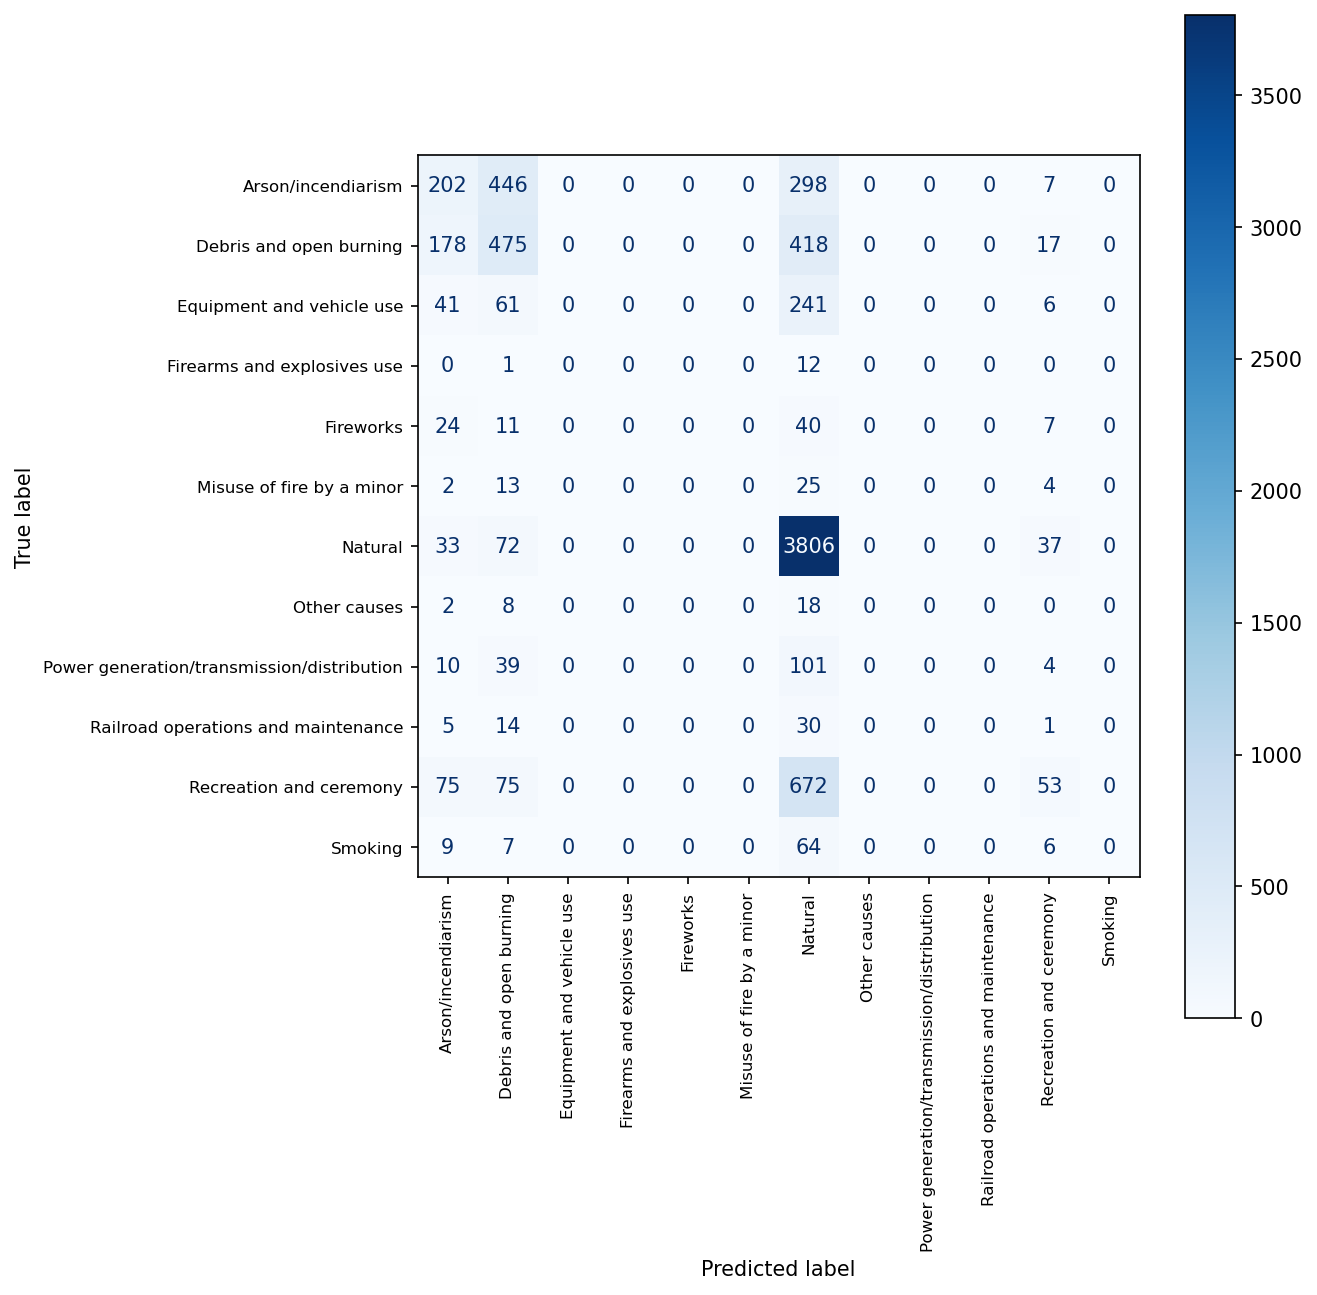

In [48]:
# Apply mapping to train and test clusters to get pseudo-class predictions
y_pred = apply_mapping(clusters, cluster_to_label)

# Confusion matrix
cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.inverse_transform(np.arange(n_classes))
)

fig, ax = plt.subplots(figsize=(9, 9), dpi=150)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.inverse_transform(np.arange(n_classes))
)
disp.plot(cmap="Blues", ax=ax, colorbar=True, values_format=".0f")
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [55]:
# Metrics on alignment of clusters with true labels
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred, average="weighted", zero_division=0)
rec = recall_score(y, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y, y_pred, average="weighted", zero_division=0)

print(f"Cluster-label alignment accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted):    {rec:.4f}")
print(f"F1 (weighted):        {f1:.4f}")

Cluster-label alignment accuracy: 0.5914
Precision (weighted): 0.4831
Recall (weighted):    0.5914
F1 (weighted):        0.5080


In [56]:
# Natural vs human accuarcy
natural_idx = np.where(le.classes_ == 'Natural')[0][0]  # Find Natural class index
y_test_binary = (y == natural_idx).astype(int)  # 1=Natural, 0=Human
y_pred_binary = (y_pred == natural_idx).astype(int)

natural_human_accuracy = accuracy_score(y_test_binary, y_pred_binary)

print(f"Natural vs Human:   {natural_human_accuracy:.4f}")

Natural vs Human:   0.7313
